# Regression w/ California Housing

### import

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# import 
import torch
import torch.nn as nn # class Model(nn.Module)
from torch.utils.data import Dataset, DataLoader

In [ ]:
from sklearn.datasets import fetch_california_housing

ch =  fetch_california_housing()
df = pd.DataFrame(ch.data, columns = ch.feature_names)
df['target'] = ch.target
print(df.shape)
df.head()

(20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Set SEED

In [ ]:
import os
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When Running on the CuDNN backend, two further options muset be set
    torch.backends.cudnn.deteministic =True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
# print(config['seed'])
set_seed(2022)

### Dataset -> DataLoader

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df = df):
        self.df = df
        self.x = df.iloc[:, :-1].values # numpy
        self.y = df.iloc[:, -1:].values # numpy

    # Dataset 상속시 오버라이드 1
    def __len__(self):
        # 데이터셋의 전체 길이 정보(= all rows)를 반환
        return self.x.shape[0] # len(self.df)

    # Dataset 상속시 오버라이드 2
    def __getitem__(self, index):   
        # index로 row를 특정하고 x, y를 뱉어줍니다.
        x = self.x[index] # 8
        y = self.y[index] # 1
        # return x, y
        return torch.tensor(x, dtype = torch.float), torch.tensor(y, dtype = torch.float)
        

In [ ]:
ds = MyDataset()
s = next(iter(ds))
s[0].shape, s[1].shape

(torch.Size([8]), torch.Size([1]))

In [ ]:
def prepare_loaders(df = df, bs= 256, index_num = 15640):
    # 1) Train, Valid Split
    train = df[:index_num].reset_index(drop=True)
    valid = df[index_num:].reset_index(drop=True)
    # 2) MyDATASET
    train_ds = MyDataset(df = train)
    valid_ds = MyDataset(df = valid)
    # 3) DataLoader
    train_loader = DataLoader(train_ds, batch_size = bs, shuffle = True, 
                            #   drop_last = True,
                            # pin_memory = True, num_workers = 2, # 저만의 공식: 내 컴이 아니면 쓴다.
                              )
    
    valid_loader = DataLoader(valid_ds, batch_size = bs, shuffle = True)
    print("DataLoader COmpleted")
    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader =prepare_loaders(df = df, bs= 256, index_num = 15640)

DataLoader COmpleted


In [ ]:
s = next(iter(train_loader))
s[0].shape, s[1].shape

(torch.Size([256, 8]), torch.Size([256, 1]))

### Model


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# model, parameter, ... 친구들 GPU로 보내서 연산을 시켜주는 목적

In [ ]:
torch.cuda.is_available()

True

In [ ]:
a = torch.randn(1, 2)
a

tensor([[-0.2044, -0.9081]])

In [ ]:
b = a.to(device)
b

tensor([[-0.2044, -0.9081]], device='cuda:0')

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim =8, output_dim=1):
        super().__init__()

        # frame을 선언
        # shape 추적 필수
        # x(=input): shape? [bs, 8]
        self.fc1  = nn.Linear(input_dim, 4)
        # [bs, 8] -> [bs, 4]

        self.relu = nn.ReLU()
        # [bs, 4] -> [bs, 4]

        self.fc2 = nn.Linear(4, output_dim)
        # [bs, 4] -> [bs, 1]


    # nn.Module 상속시 반드시 오버라이드
    def forward(self, x):
        # 엮어주기 함수처럼
        y = self.fc2(self.relu(self.fc1(x)))
        return y


In [ ]:
model = Model().to(device)
model

Model(
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

### Lossfunction, Optimizer

In [ ]:
loss_fn = nn.MSELoss().to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 
                            #  lr= 
                             )
#.to(device)

### train_one_epoch

In [ ]:
epoch= 1
def train_one_epoch(model = model, dataloader = train_loader, device = device,
                    loss_fn = loss_fn, optimizer = optimizer, epoch = epoch):
    # model 학습시키겠다는 의지 표명
    model.train()
    train_loss = 0
    for data in dataloader:
        # train_loader =[[bs, 8], [bs, 8], [bs, 8], ....]
        x = data[0].to(device) # x: [bs, 8]
        y = data[1].to(device) # y: [bs, 1]
        y_pred = model(x) # y_pred: [bs, 1]

        loss = loss_fn(y_pred, y)

        # 딥러닝에서 가장 중요한 짓
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(dataloader)
    return train_loss

### valid one epoch

In [ ]:
epoch= 1

# model을 학습 시키지 않겠다는 필수 의지 표명 2
@torch.no_grad()
def valid_one_epoch(model = model, dataloader = valid_loader, device = device,
                    loss_fn = loss_fn, epoch = epoch):
    # model 학습 안 시키겠다는 의지 표명
    model.eval()
    valid_loss = 0

    # model을 학습 시키지 않겠다는 필수 의지 표명 1
    with torch.no_grad():
        for data in dataloader:
            # train_loader =[[bs, 8], [bs, 8], [bs, 8], ....]
            x = data[0].to(device) # x: [bs, 8]
            y = data[1].to(device) # y: [bs, 1]
            y_pred = model(x) # y_pred: [bs, 1]

            loss = loss_fn(y_pred, y)

            valid_loss += loss.item()

    valid_loss /= len(dataloader)

    return valid_loss

### Run Train

In [ ]:
def run_train(model = model, train_loader = train_loader, valid_loader = valid_loader,
              device = device, loss_fn = loss_fn, optimizer = optimizer, n_epochs = 120):
    
    result = dict()
    train_hs, valid_hs = [],  []
    print_iter = 10
    early_stop = 20
    lowest_loss, lowest_epoch = np.inf, np.inf

    for epoch in range(1, 1 + n_epochs):

        train_loss = train_one_epoch(model = model, dataloader = train_loader, device = device,
                                     loss_fn = loss_fn, optimizer = optimizer, epoch = epoch)
        valid_loss = valid_one_epoch(model = model, dataloader = valid_loader, device = device,
                                     loss_fn = loss_fn, epoch = epoch)
        
        # 줍줍
        train_hs += [train_loss]
        valid_hs.append(valid_loss)

        # monitoring
        if epoch % print_iter == 0:
            print(f"Epoch{epoch:02d}|TL:{train_loss:.3e}|VL:{valid_loss:.3e}|LL:{lowest_loss:.3e}|")
        
        # Lowest Loss 갱싱  -> Valid Loss 기준
        if valid_loss < lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = epoch
            torch.save(model.state_dict(), './model.pt') # bin -> 큰 모델 
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch:
                print("넌 삽질 중")
                break

    print(f"The Best Validation Loss: {lowest_loss:.4f} at {lowest_epoch:02d} EPoch")

    # model load
    model.load_state_dict(torch.load('./model.pt'))

    result["Train Loss"] = train_hs
    result["Valid Loss"] = valid_hs

    return model, result

In [ ]:
model, result = run_train()

Epoch10|TL:6.642e-01|VL:8.048e-01|LL:7.995e-01|
Epoch20|TL:6.511e-01|VL:7.846e-01|LL:7.869e-01|
Epoch30|TL:6.269e-01|VL:7.594e-01|LL:7.552e-01|
Epoch40|TL:6.085e-01|VL:7.905e-01|LL:7.490e-01|
Epoch50|TL:6.283e-01|VL:8.927e-01|LL:7.487e-01|
Epoch60|TL:5.936e-01|VL:7.567e-01|LL:7.403e-01|
Epoch70|TL:6.004e-01|VL:8.182e-01|LL:7.225e-01|
Epoch80|TL:5.820e-01|VL:8.061e-01|LL:7.225e-01|
넌 삽질 중
The Best Validation Loss: 0.7225 at 65 EPoch


### Visualization

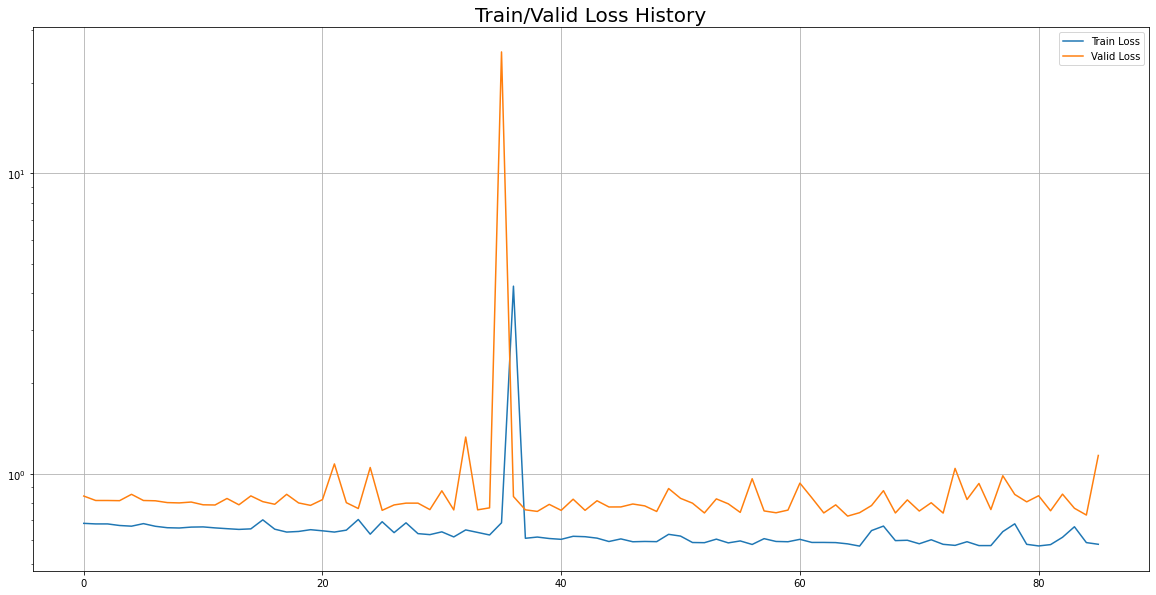

In [ ]:
## Train/Valid History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()